# **SETUP**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install --upgrade transformers
!pip install simpletransformers
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

# **Importing libraries**

In [4]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.8 GB  |     Proc size: 99.2 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total     15109MB


In [5]:
import numpy as np
import pandas as pd
from google.colab import files
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import sklearn
from sklearn.metrics import log_loss
from sklearn.metrics import *
from sklearn.model_selection import *
import re
import random
import torch
pd.options.display.max_colwidth = 200

In [6]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(2)

# **Load the dataset**

In [7]:
# Testing path
path = "/content/drive/MyDrive/BankTransactionClassifier/"

In [8]:
# Load the files into a Pandas Dataframe
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
ss = pd.read_csv(path+'SampleSubmission.csv')
testID = test["ID"]

In [9]:
selectCol = ["DATE", "TRANSACTION DETAILS", "Account_NO", "WITHDRAWAL AMT", "DEPOSIT AMT", "BALANCE AMT"]
label = ["Category"]

In [10]:
import re
train = train[selectCol + label].dropna()
test = test[selectCol]

train["TRANSACTION DETAILS"] = train["TRANSACTION DETAILS"].apply(lambda x : re.sub(r'\W','',str(x)))
test["TRANSACTION DETAILS"] = test["TRANSACTION DETAILS"].apply(lambda x : re.sub(r'\W','',str(x)))

In [11]:
#train["TRANSACTION DETAILS"] = train["TRANSACTION DETAILS"].apply(lambda x : re.sub(r'\d','',str(x)))
#test["TRANSACTION DETAILS"] = test["TRANSACTION DETAILS"].apply(lambda x : re.sub(r'\d','',str(x)))

In [12]:
def getKmers(sequence, size = 6):
  return [sequence[x:x+size] for x in range(len(sequence) - size + 1)]

def createNewSequence(sequence):
  newSeq = [sequence]
  for size in [3, 4, 5, 6, 7]:
    newSeq = newSeq + getKmers(sequence, size = 6)
  return re.sub("\s\d*\s", " NUMBERS "," ".join(newSeq))

In [13]:
createNewSequence(sequence = "NEFTFDRL401249529INDIAFORENSIC")

'NEFTFDRL401249529INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249529 49529I 9529IN 529IND 29INDI 9INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS ORENSI RENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249529 49529I 9529IN 529IND 29INDI 9INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS ORENSI RENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249529 49529I 9529IN 529IND 29INDI 9INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS ORENSI RENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249529 49529I 9529IN 529IND 29INDI 9INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS ORENSI RENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249529 49529I 9529IN 529IND 29INDI 9INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS ORENSI RENSIC'

In [14]:
train["Sequence"] = train["TRANSACTION DETAILS"].apply(lambda x: createNewSequence(str(x)))
test["Sequence"] = test["TRANSACTION DETAILS"].apply(lambda x: createNewSequence(str(x)))

train["Sequence_Length"] = train["Sequence"].apply(lambda x: len(x.split()))
test["Sequence_Length"] = test["Sequence"].apply(lambda x: len(x.split()))

In [15]:
train.head()

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,Sequence,Sequence_Length
0,2014-02-28,NEFTFDRL401249529INDIAFORENSIC,84903292,0.0,15000000.0,15000000.0,Money-Transfer,NEFTFDRL401249529INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249529 49529I 9529IN 529IND 29INDI 9INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126
1,2014-02-28,NEFTFDRL401249532INDIAFORENSIC,84903292,0.0,15000000.0,60000000.0,Money-Transfer,NEFTFDRL401249532INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249532 49532I 9532IN 532IND 32INDI 2INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126
2,2014-02-28,NEFTFDRL401249534INDIAFORENSIC,84903292,0.0,15000000.0,90000000.0,Money-Transfer,NEFTFDRL401249534INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249534 49534I 9534IN 534IND 34INDI 4INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126
3,2014-02-28,NEFTFDRL401249590INDIAFORENSIC,84903292,0.0,10000000.0,100000000.0,Money-Transfer,NEFTFDRL401249590INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249590 49590I 9590IN 590IND 90INDI 0INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126
4,2014-02-28,NEFTFDRL401249531INDIAFORENSIC,84903292,0.0,15000000.0,45000000.0,Money-Transfer,NEFTFDRL401249531INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249531 49531I 9531IN 531IND 31INDI 1INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126


In [16]:
train["TRANSACTION DETAILS"].value_counts()

INTERNALFUNDTRANSFERIN          3262
TRFFROMINDIAFORENSICSERVICES    1746
CASHDEPKAROLBAGH                1649
CASHDEPRAJOURI                  1538
CASHDEPNOIDATP                  1455
                                ... 
NEFTKKBK162254867231ACC            1
NEFTKKBK162254867238ACC            1
NEFTKKBK162254867237ACC            1
NEFTKKBK162254867226ACC            1
NEFTSBHY717058731043BYA            1
Name: TRANSACTION DETAILS, Length: 29353, dtype: int64

In [17]:
test.head()

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Sequence,Sequence_Length
0,2014-02-28,NEFTFDRL401249530INDIAFORENSIC,84903292,0.00,15000000.0,30000000.00,NEFTFDRL401249530INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249530 49530I 9530IN 530IND 30INDI 0INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126
1,2014-02-28,NEFTFDRL401249533INDIAFORENSIC,84903292,0.00,15000000.0,75000000.00,NEFTFDRL401249533INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249533 49533I 9533IN 533IND 33INDI 3INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126
2,2014-03-08,RTGSCHARGESANDSTAXRAT,84903292,28.63,0.0,45000028.63,RTGSCHARGESANDSTAXRAT RTGSCH TGSCHA GSCHAR SCHARG CHARGE HARGES ARGESA RGESAN GESAND ESANDS SANDST ANDSTA NDSTAX DSTAXR STAXRA TAXRAT RTGSCH TGSCHA GSCHAR SCHARG CHARGE HARGES ARGESA RGESAN GESAND...,81
3,2014-03-08,RTGSYESBH16068986176INDFOR,84903292,15000000.00,0.0,60000028.63,RTGSYESBH16068986176INDFOR RTGSYE TGSYES GSYESB SYESBH YESBH1 ESBH16 SBH160 BH1606 H16068 NUMBERS 606898 NUMBERS 689861 NUMBERS 986176 86176I 6176IN 176IND 76INDF 6INDFO INDFOR RTGSYE TGSYES GSYES...,106
4,2014-03-08,RTGSCHARGESANDSTAXRAT,84903292,28.63,0.0,60000057.26,RTGSCHARGESANDSTAXRAT RTGSCH TGSCHA GSCHAR SCHARG CHARGE HARGES ARGESA RGESAN GESAND ESANDS SANDST ANDSTA NDSTAX DSTAXR STAXRA TAXRAT RTGSCH TGSCHA GSCHAR SCHARG CHARGE HARGES ARGESA RGESAN GESAND...,81


In [18]:
train["train"] = 1
test["train"] = 0

data = pd.concat([train, test], axis = 0)

In [19]:
data.head()

,DATE,TRANSACTION DETAILS,Account_NO,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Category,Sequence,Sequence_Length,train
0,2014-02-28,NEFTFDRL401249529INDIAFORENSIC,84903292,0.0,15000000.0,15000000.0,Money-Transfer,NEFTFDRL401249529INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249529 49529I 9529IN 529IND 29INDI 9INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126,1
1,2014-02-28,NEFTFDRL401249532INDIAFORENSIC,84903292,0.0,15000000.0,60000000.0,Money-Transfer,NEFTFDRL401249532INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249532 49532I 9532IN 532IND 32INDI 2INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126,1
2,2014-02-28,NEFTFDRL401249534INDIAFORENSIC,84903292,0.0,15000000.0,90000000.0,Money-Transfer,NEFTFDRL401249534INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249534 49534I 9534IN 534IND 34INDI 4INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126,1
3,2014-02-28,NEFTFDRL401249590INDIAFORENSIC,84903292,0.0,10000000.0,100000000.0,Money-Transfer,NEFTFDRL401249590INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249590 49590I 9590IN 590IND 90INDI 0INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126,1
4,2014-02-28,NEFTFDRL401249531INDIAFORENSIC,84903292,0.0,15000000.0,45000000.0,Money-Transfer,NEFTFDRL401249531INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249531 49531I 9531IN 531IND 31INDI 1INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,126,1


In [20]:
data["Sequence_Length"].min(), data["Sequence_Length"].max()

(1, 131)

In [21]:
unique_classes = data.Category.unique()
print("Number of Classes: ", len(unique_classes))
unique_classes

Number of Classes:  22


array(['Money-Transfer', 'Salary and wages', 'Bank Charges',
       'Cash-Pickup', 'Cheque-Payment', 'Deposit', 'Merchant-Payment',
       'Reversal', 'Savings and Investments', 'Internet and IT Services',
       'Bill-Payments', 'Shopping', 'Interest',
       'Transport, Travel, and Logistics', 'Insurance',
       'Cell Phone and Airtime', 'Entertainment', 'Professional services',
       'General Purchases', 'Donations', 'Loan Repayment', nan],
      dtype=object)

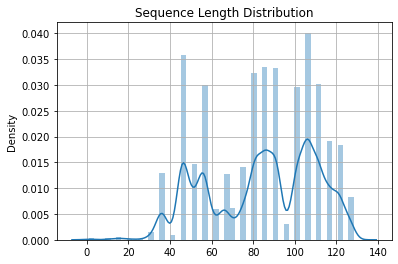

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(data["Sequence_Length"].values)
plt.title("Sequence Length Distribution")
plt.grid(True)


In [23]:
categories = train.Category.astype('category').cat
class_names = categories.categories
class_codes = categories.codes
num_classes = len(class_names)
print(class_names)

Index(['Bank Charges', 'Bill-Payments', 'Cash-Pickup',
       'Cell Phone and Airtime', 'Cheque-Payment', 'Deposit', 'Donations',
       'Entertainment', 'General Purchases', 'Insurance', 'Interest',
       'Internet and IT Services', 'Loan Repayment', 'Merchant-Payment',
       'Money-Transfer', 'Professional services', 'Reversal',
       'Salary and wages', 'Savings and Investments', 'Shopping',
       'Transport, Travel, and Logistics'],
      dtype='object')


In [24]:
len(categories.categories)

21

In [25]:
train  = train.drop(["train"], axis = 1)
test  = test.drop(["train"], axis = 1)

In [26]:
train["Label"] = categories.codes

In [27]:
train1 = pd.DataFrame()
train1["text"] = train["Sequence"]
train1["target"] = train["Label"]

test1 = pd.DataFrame()
test1["text"] = test["Sequence"]
test1["label"] = 0

In [28]:
train1["target"].value_counts()

14    33555
5     12431
13     3160
4      1427
0      1122
2      1064
17      808
1       482
19      119
3       103
10       70
12       69
16       66
11       22
9        20
15       15
18       10
8         4
20        2
6         2
7         1
Name: target, dtype: int64

In [29]:
lessrepclasses  = train1.set_index("target").loc[[15,18,8,20,6,7], :].reset_index()

In [30]:
train1.head()

,text,target
0,NEFTFDRL401249529INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249529 49529I 9529IN 529IND 29INDI 9INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,14
1,NEFTFDRL401249532INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249532 49532I 9532IN 532IND 32INDI 2INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,14
2,NEFTFDRL401249534INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249534 49534I 9534IN 534IND 34INDI 4INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,14
3,NEFTFDRL401249590INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249590 49590I 9590IN 590IND 90INDI 0INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,14
4,NEFTFDRL401249531INDIAFORENSIC NEFTFD EFTFDR FTFDRL TFDRL4 FDRL40 DRL401 RL4012 L40124 NUMBERS 012495 NUMBERS 249531 49531I 9531IN 531IND 31INDI 1INDIA INDIAF NDIAFO DIAFOR IAFORE AFOREN FORENS OR...,14


# **Roberta Large Model 1**

In [31]:
%%time
model = ClassificationModel('roberta', 'roberta-large', use_cuda=True,num_labels=21, args={'train_batch_size':32,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': 2,
                                                                         'max_seq_length': 100,
                                                                         'regression': False,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":3e-5,
                                                                         'weight_decay':0,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "silent": True})
model.train_model(train1)
raw_outputs_test = model.eval_model(test1)[1]
raw_outputs_test = softmax(raw_outputs_test,axis=1)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

CPU times: user 1h 37min 5s, sys: 18min 20s, total: 1h 55min 25s
Wall time: 1h 56min 50s


In [32]:
final=pd.DataFrame()
final['ID']=testID
final[class_names] = raw_outputs_test
print(final.shape)

(22625, 22)


In [33]:
final.to_csv(f'{path}RobertaLarge1.csv',index=False)

In [34]:
final.head()

,ID,Bank Charges,Bill-Payments,Cash-Pickup,Cell Phone and Airtime,Cheque-Payment,Deposit,Donations,Entertainment,General Purchases,...,Internet and IT Services,Loan Repayment,Merchant-Payment,Money-Transfer,Professional services,Reversal,Salary and wages,Savings and Investments,Shopping,"Transport, Travel, and Logistics"
0,2014-02-28 00:00:00X3000000000,0.000002,0.000004,0.000002,0.000001,0.000021,0.000002,0.000002,8.578564e-07,0.000002,...,7.417627e-07,9.073775e-07,0.000002,0.999948,0.000002,0.000003,0.000001,0.000001,9.100655e-07,0.000001
1,2014-02-28 00:00:00X7500000000,0.000002,0.000004,0.000002,0.000001,0.000021,0.000002,0.000002,8.556220e-07,0.000002,...,7.397737e-07,9.105360e-07,0.000002,0.999948,0.000002,0.000003,0.000001,0.000001,9.149205e-07,0.000001
2,2014-03-08 00:00:00X4500002863,0.999441,0.000012,0.000020,0.000012,0.000006,0.000015,0.000011,1.609985e-05,0.000017,...,8.427988e-06,1.870558e-05,0.000017,0.000123,0.000013,0.000160,0.000012,0.000022,8.504165e-06,0.000017
3,2014-03-08 00:00:00X6000002863,0.000002,0.000004,0.000002,0.000001,0.000020,0.000002,0.000002,8.088602e-07,0.000002,...,7.547250e-07,8.659647e-07,0.000002,0.999949,0.000003,0.000003,0.000001,0.000001,9.300149e-07,0.000001
4,2014-03-08 00:00:00X6000005726,0.999441,0.000012,0.000020,0.000012,0.000006,0.000015,0.000011,1.609985e-05,0.000017,...,8.427988e-06,1.870558e-05,0.000017,0.000123,0.000013,0.000160,0.000012,0.000022,8.504165e-06,0.000017


In [35]:
final.to_csv('RobertaLarge1.csv',index=False)